<a href="https://colab.research.google.com/github/elolaine/AI4Biologists/blob/main/notebooks/iBio_SS_GDL_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric Deep Learning for Molecules
#### Sergei Grudinin<sup>1</sup>, Ilia Igashov<sup>1</sup>, Margot Selosse<sup>1</sup>, Dmitrii Zhemchuzhnikov<sup>1</sup> 
#### 1: [Graph Ticklers ... Fan Club](https://youtube.com/watch?v=pV-4HH6BxY0&t=29s&ab_channel=%E1%9B%97%E1%9B%81%E1%9A%BB%E1%9A%BB%E1%9A%A8%E1%9B%81%E1%9B%9A&t=29s)


This tutorial will start with the introduction to the PyTorch Geometric library. It will then present a basic description of graph-learning architectures, including convolution and attention operations. The first examples will include binary classification of 3D protein structures. After, we will apply the presented architectures to the regression task for the properties prediction of small molecules in the QM9 dataset. In the end, we will introduce more advanced architectures, specifically constructed to be rotation and translation equivariant, for the property predictions of 3D molecular graphs.

# Contents

- Prerequisites
- What are the graphs?
- PyTorch Geometric and NetworkX basics
- Graph notations
- Message Passing
- Graph Convolutional Network (GCN)
- Graph Attention Network (GAT)
- Graph Classification on PROTEINS dataset
- Graph Regression with QM9 dataset
- SchNet and Equivariance
- Further reading

# Prerequisites

We will be using PyTorch Geometric and NetworkX – popular frameworks for working with graphs. 



In [177]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install ase

!mkdir data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘data’: File exists


In case you are going to run the notebook locally, you may need to do some additional installations (if you do not have this packages installed yet):

* `numpy`
* `matplotlib`
* `torch`
* `tqdm`
* `networkx`

# What are the graphs?

A graph is a structure consisting of nodes and edges between them. For each node, we know the set of its neighbors and sometimes features of this node and edges with the neighbors. There are two types of graphs: directed and undirected.



<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?export=view&id=1AeCq5cwRxc3qESttp7_l6OJVlK9RdEDo" width="500">
    <br>
    <em style="color: grey">Undirected graph (just connections)</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?export=view&id=1TJKORu9rbOob3VhoqrW_iZR9VO_aFFSb" width="500">
    <br>
    <em style="color: grey">Directed graph (financial flows)</em>
  </p> 
</td>
</tr></table>

# PyTorch Geometric and NetworkX basics

We will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) (PyG) framework as the main tool for working with graphs. It provides a convenient functionality for operating on:
- [graph structures](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html)
- [graph-learning models](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html)
- [common graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)

Besides, [NetworkX](https://networkx.org/) (NX) library is useful for graph visualization.

In [178]:
import torch
import networkx as nx

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

<script>
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

Let's create a simple graph with four nodes and four edges, where each node $v_i$ will have an associated feature value, its index $i$:
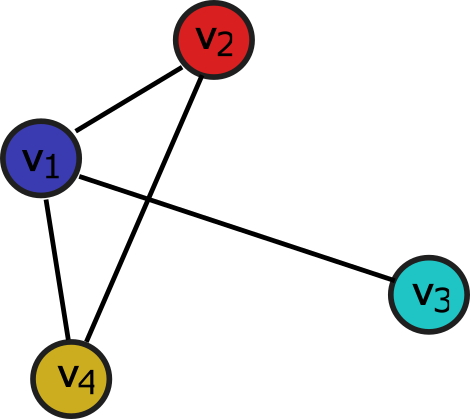

**Note:** PyG treats the graph as **directed** by default. Therefore, our **undirected** graph with 4 edges, we represent as a **directed** graph with 8 edges.

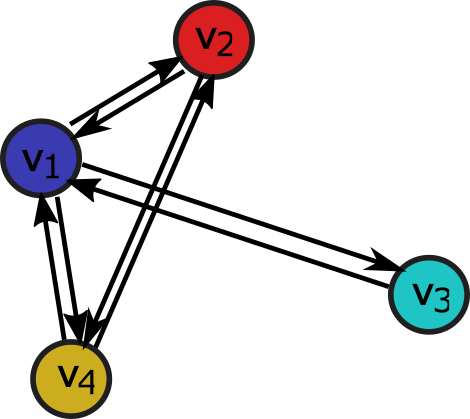



In [179]:
# node features – indices:
x = torch.tensor([[0], [1], [2], [3]], dtype=torch.long)

# edges of the graph:
edge_index = torch.tensor(
    [
        [0, 0, 0, 1, 1, 2, 3, 3],
        [1, 2, 3, 0, 3, 0, 0, 1],
    ], 
    dtype=torch.long
)

# PyG graph:
pg_graph = Data(x=x, edge_index=edge_index)

Let's look at the created PyG graph object:

In [180]:
pg_graph

Data(x=[4, 1], edge_index=[2, 8])

Useful graph attributes:

In [181]:
print('Number of nodes in the graph:', pg_graph.num_nodes)
print('Number of edges in the graph:', pg_graph.num_edges)
print('Number of node features:', pg_graph.num_node_features)

Number of nodes in the graph: 4
Number of edges in the graph: 8
Number of node features: 1


Note that `edge_index`, i.e. the tensor defining the source and target nodes of all edges, **is not a list of index tuples**. If you want to write your indices this way, you should transpose and call `contiguous` on it before passing them to the data constructor:

In [182]:
edge_index = torch.tensor(
    [
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 3], 
        [2, 0],
        [3, 0],
        [3, 1],
    ], 
    dtype=torch.long
)

edge_index.t().contiguous()

tensor([[0, 0, 0, 1, 1, 2, 3, 3],
        [1, 2, 3, 0, 3, 0, 0, 1]])

Let's transform PyG graph to the NX format and draw the resulting graph:

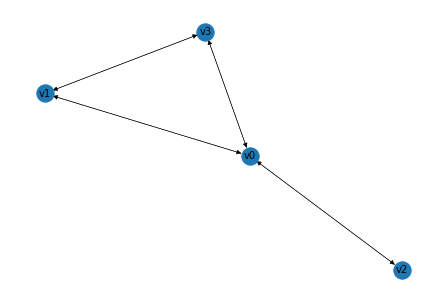

In [183]:
# transform:
nx_graph = to_networkx(pg_graph)

# draw:
nx.draw(
    nx_graph, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{pg_graph.x[i][0]}' for i in range(pg_graph.num_nodes)},
)

Now let's create the second simple graph with two nodes and one edge:

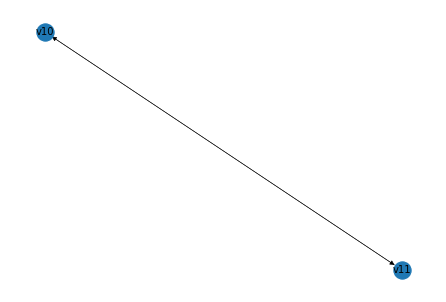

In [184]:
second_pg_graph = Data(
    x=torch.tensor([[10], [11]], dtype=torch.long),
    edge_index=torch.tensor([[0, 1], [1, 0]], dtype=torch.long),
)

second_nx_graph = to_networkx(second_pg_graph)

nx.draw(
    second_nx_graph, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{second_pg_graph.x[i][0]}' for i in range(second_pg_graph.num_nodes)},
)

Let's put both graphs into DataLoader with `batch_size=2`:

In [185]:
loader = DataLoader([pg_graph, second_pg_graph], batch_size=2)

Let's check how many batches the loader is going to generate:

In [186]:
len(loader)

1

Let's see what the loader yields:

In [187]:
for batch in loader:
    print(batch)

DataBatch(x=[6, 1], edge_index=[2, 10], batch=[6], ptr=[3])


The batch object is very similar to the `Data` object, but it has additonal attribute `ptr` that defines ranges of nodes' indices that belong to different graphs in the batch:

In [188]:
batch.ptr

tensor([0, 4, 6])

In [189]:
batch.batch

tensor([0, 0, 0, 0, 1, 1])

That means that nodes with indices $0\leq{i}<4$ belong to the first graph in the batch, and nodes with indices $4\leq{i}<6$ belong to the second graph in a batch. For checking that, let's take a look at the attribute `x` of the batch:

In [190]:
batch.x

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [10],
        [11]])

So the batch of size $B$ can be thought as a new big graph that contains $B$ disjoint components corresponding to the graphs included in this batch:

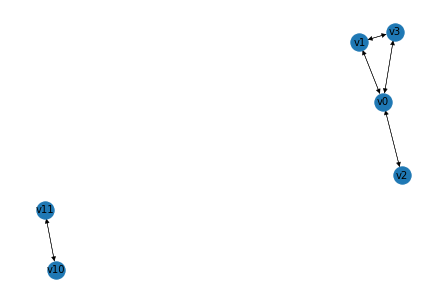

In [191]:
nx_batch = to_networkx(batch)

nx.draw(
    nx_batch, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{batch.x[i][0]}' for i in range(batch.num_nodes)},
)

# Graph notations

Let's consider an *undirected graph* $G=(V, E)$, where $V$ is the set of nodes and $E$ is the set of edges.
For a graph node $u\in V$, we define its neighborhood as 

$$
N(u)=\{v\in{V}\ |\ (u,v)\in E\}.
$$

The adjacency matrix $\boldsymbol{A}$ of graph $G$ is a square $|V|\times|V|$ symmetric matrix where each entry relates to an edge between the corresponding nodes. In case of the *weigted* graph, when each edge $(v_i,v_j)\in E$ has weight $w_{ij}\in\mathbb{R}$, the corresponding entry of the adjacency matrix $a_{ij}$ equals to this weight:

$$
\forall {i,j}\in\{1,\dots,|V|\}\ \ \ \ a_{ij}=
\begin{cases}
w_{ij},\ &\text{if}\ (v_i,v_j)\in{E},\\
0,\ &\text{if}\ (v_i,v_j)\notin{E}.
\end{cases}
$$


In case of the *unweighted* graph, the adjacency matrix is binary:

$$
\forall {i,j}\in\{1,\dots,|V|\}\ \ \ \ a_{ij}=
\begin{cases}
1,\ &\text{if}\ (v_i,v_j)\in{E},\\
0,\ &\text{if}\ (v_i,v_j)\notin{E}.
\end{cases}
$$

# Message Passing

Graph Neural Networks (GNNs) rely on a more generic framework referred to as "Message Passing" that proceeds as follows.

Assume that each node $v_i$ of the input graph $G$ has an associated vector of features $\boldsymbol{z}_i^{0}$ of size $d^0$. Consider $K$ message-passing layers. 

For $k \in \{1,\ldots,K\}$:

* For all nodes $v_i$ and for all its neighbours, we build a message $\color{red}{\boldsymbol{m}_{ij}^{k}}$ with some differentiable function $\phi$:

\begin{equation}
\color{red}{\boldsymbol{m}_{ij}^{k} \leftarrow \phi(z_i^{k-1},z_j^{k-1})},  \tag{1} 
\end{equation}


* We aggregate the messages in $\color{green}{\boldsymbol{h}_i^{k}}$, a vector of size $d^{k-1}$, using some differentiable and permutation invariant function AGGR:

\begin{equation}
\color{green}{\boldsymbol{h}_i^{k} \leftarrow \text{AGGR}(\{ \color{red}{\boldsymbol{m}_{ij}^{k}}, \forall v_j \in N(v_i)  \}, \color{red}{\boldsymbol{m}_{ii}^{k}})},\tag{2}
\end{equation}

* We build a new embedding $\boldsymbol{z}^{k}_i$ for each node $v_i$ with $\boldsymbol{W}^{k}$ a matrix of size $d^{k}\times d^{k-1}$:

$$
\boldsymbol{z}^{k}_i \leftarrow \sigma(\boldsymbol{W}^{k} . \color{green}{\boldsymbol{h}_i^{k}}).\tag{3}
$$
    

Finally, we set the embedding of node $i$ as $\boldsymbol{z}_i=\boldsymbol{z}^{K}_i$.

<div>
<img src="https://miro.medium.com/max/1400/1*fPzRm3Flq3dQErn7LEG_Ig.png" width="900"/>
</div>

Note that the user has to choose:

* the number of layers $K$,
* The $\phi$ function,
* the AGGR function, which is an aggregation function (e.g: max, sum, mean),
* the dimensions $d^{k}$ for $k \geq 1$
* $\sigma$, which is a non-linear function (e.g ReLU).

### How to aggregate?

When we want to update the feature vector $z'_i$ of a node at some layer we use the following data from the previous layer:

  1. the message from this node to itself $m_{i,i}$ 
  2. the *multiset* of messages from its neighbors  to this node \begin{equation}\{m_{i,j}, \forall v_j \in N(v_i) \} \end{equation}

We say *multiset* because the neighborhood of each node is unordered but there can be repeating messages. 

**How can we process a *multiset*?**

There are several main approaches:

  1. *Mean*:
    \begin{equation}
      f(\{m_{i,j}, \forall v_j \in N(v_i) \}) = \color{red}{\frac{1}{\text{deg}(v_i)}}  \sum_{v_j \in N(v_i)} m_{i,j},
    \end{equation}
  where $\text{deg}(v)$ is a degree of the node $v$:

$$
\text{deg}(v) = \sum_{u\in{V}}\mathbb{I}\{(u,v)\in{E}\}.
$$
  
  2. *Sum*:
    \begin{equation}
      f(\{m_{i,j}, \forall v_j \in N(v_i) \}) =  \sum_{v_j \in N(v_i)} m_{i,j} 
    \end{equation}

  3. *Max*
    \begin{equation}
      f(\{m_{i,j}, \forall v_j \in N(v_i) \}) =  \max(\{m_{i,j}, \forall v_j \in N(v_i) \}),
    \end{equation}
  if we can propose a way how to compare messages:
  $$
  \forall v_j, v_k: m_{i,j} < m_{i,k} \text{ or } m_{i,j} = m_{i,k} \text{ or } m_{i,j} > m_{i,k}  
  $$


**What type of multiset aggregation is better?**

We would like to choose the most expressive aggregation where by expressiveness we mean the ability to distinguish different multisets. Let's assume that different colors are assigned to different messages values and consider this illustration:

<div>
<img src="https://drive.google.com/uc?export=view&id=1RcqOiDRgXMUS20aup3QSnZHDqQ9Bj6ox" width="900"/>
</div>

[HOW POWERFUL ARE GRAPH NEURAL NETWORKS?](https://arxiv.org/pdf/1810.00826.pdf)

On the picture we see that in some cases *mean* and *max* aggregations are less expressive than the *sum*  aggregation. Moreover, we can conclude that the *sum* aggregation is the most suitable for multisets:
<div>
<img src="https://drive.google.com/uc?export=view&id=1o_PJw9AjvhI4ZGw9YpFbH2VDgRO2-bx2" width="900"/>
</div>

Graoh Neural Networks very often engage some mix of *mean* and *sum* aggregations that has the same expressiveness as the *sum*:

\begin{equation}
      f(\{m_{i,j}, \forall v_j \in N(v_i) \}) = \color{red}{\frac{1}{\sqrt{\text{deg}(v_i)}}}  \sum_{v_j \in N(v_i)} m_{i,j}.
\end{equation}

In fact, the choice of multipliers in this sum is the matter of normalization that we consider later, but the expressiveness of the *sum* aggregation should be achieved. 


## Graph Convolutional Network

* [original paper](https://arxiv.org/abs/1609.02907)
* [original code](https://github.com/tkipf/gcn)

The Graph Convolutional Network (GCN) is a graph neural network that implements the Message Passing framework such that:

$$
\boldsymbol{z}'_i = \sigma\left[
\color{green}{\sum_{v_j\in{N}(v_i)\cup\{v_i\}}}
\color{red}{
\frac{1}{\sqrt{\text{deg}(v_i) + 1}\sqrt{\text{deg}(v_j) + 1}}
}
\boldsymbol{\Theta}\boldsymbol{z}_j\right]
,\tag{4}
$$

where $\boldsymbol{\Theta}$ is a weight matrix, and $\text{deg}(v)$ is a degree of the node $v$:

$$
\text{deg}(v) = \sum_{u\in{V}}\mathbb{I}\{(u,v)\in{E}\}.\tag{5}
$$

**Note:** for simplicity, we dropped indices $k$ corresponding to the layer's number. Instead, we use prime `'` as an indication of the updated embeddings. We assume that each node $v_i$ has an embedding vector $\boldsymbol{z}_i\in\mathbb{R}^d$ before applying the convolution layer, and gets an updated embedding vector $\boldsymbol{z}'_i\in\mathbb{R}^{d'}$ after applying the convolution layer.

### GCN modifications
  1. $$
\boldsymbol{z}'_i = \sigma\left[
\color{green}{\sum_{v_j\in{N}(v_i)}}
\color{red}{
\frac{1}{\sqrt{\text{deg}(v_i)}\sqrt{\text{deg}(v_j)}}
}
\boldsymbol{\Theta_1}\boldsymbol{z}_j + \boldsymbol{\Theta_2}\boldsymbol{z}_i \right], \tag{6} 
$$ 
Here we impose different weight matrices on the features vector of the node and on the sum of the features vectors of its neighbors

**Note:** We make the assumption that each node has at least one neighbor

  
  2. $$
\boldsymbol{z}'_i = \sigma\left[\sigma\left(
\color{green}{\sum_{v_j\in{N}(v_i)}}
\color{red}{
\frac{1}{\sqrt{\text{deg}(v_i)}\sqrt{\text{deg}(v_j)}}
}
\boldsymbol{\Theta_1}\boldsymbol{z}_j\right)  + \boldsymbol{\Theta_2}\boldsymbol{z}_i \right] , \tag{7} 
$$ 
We apply an activation function on the terms considered in the previous paragraph separately, and then add them

### Normalization

There can also be different types of normalization. Apart from the normalization presented in Equation 4, we can also apply the following normalization:
$$
\boldsymbol{z}'_i = \sigma\left[
\color{green}{\sum_{v_j\in{N}(v_i)\cup\{v_i\}}}
\color{red}{
\frac{1}{\text{deg}(v_j) + 1}
}
\boldsymbol{\Theta}\boldsymbol{z}_j\right]
,\tag{8}
$$

## Graph Isomorphic Network
The Graph Isomorphic Network (GIN) is a graph neural network that implements the Message Passing framework such that:

\begin{equation}
z'_i = \text{MLP}(\color{red}{(1 + \epsilon)}z_i + \color{green}{\sum_{v_j \in N(v_i)}} z_j) \tag{9}
\end{equation}

However, we will test different aggregations:
\begin{equation}
z'_i = \text{MLP}(\color{red}{(1 + \epsilon)}z_i + \color{green}{\text{Agg}} (\{z_j, \forall v_j \in N(v_j)\})) \tag{10}
\end{equation}

## Graph Attention Network

* [original paper](https://arxiv.org/abs/1710.10903)
* [original code](https://github.com/PetarV-/GAT)


The Graph Attention Network (GAT) is a graph neural network that implements the Message Passing framework such that:

$$
\boldsymbol{z}'_i = \sigma\left[
\color{green}{\sum_{v_j\in{N}(v_i)\cup\{v_i\}}}
\color{red}{
\alpha_{ij} 
}
\boldsymbol{\Theta}\boldsymbol{z}_j\right]
,\tag{11}
$$

where attention coefficients $\alpha_{ij}$ are computed as follows,

$$
\alpha_{ij}=\frac{
\exp\big(\text{LeakyReLU}\big(\boldsymbol{a}^{\text{T}}[\boldsymbol{\Theta}\boldsymbol{z}_i||\boldsymbol{\Theta}\boldsymbol{z}_j]\big)\big)
}{
\sum_{v_m\in{N(v_i)}}\exp\big(\text{LeakyReLU}\big(\boldsymbol{a}^{\text{T}}[\boldsymbol{\Theta}\boldsymbol{z}_i||\boldsymbol{\Theta}\boldsymbol{z}_m]\big)\big)
}.\tag{12}
$$

Here, $||$ represents concatenation, and $\boldsymbol{a}\in\mathbb{R}^{2d'}$ is a vector of learnable parameters.

**Note:** for simplicity, we dropped indices $k$ corresponding to the layer's number. Instead, we use prime `'` as an indication of the updated embeddings. We assume that each node $v_i$ has an embedding vector $\boldsymbol{z}_i\in\mathbb{R}^d$ before applying the convolution layer, and gets an updated embedding vector $\boldsymbol{z}'_i\in\mathbb{R}^{d'}$ after applying the convolution layer.

<div>
<img src="https://miro.medium.com/max/1036/1*3D844_twutCaunYMPuo-Sw.png" width="400"/>
</div>

To stabilize the learning process of self-attention, we use *multi-head attention*. To do this we use $L$ independent attention mechanisms, or “heads” compute output features. Then, we aggregate these output feature representations:

$$
\boldsymbol{z}'_i = \sigma\left[
\sum_{l=1}^{L}\sum_{v_j\in{N}(v_i)\cup\{v_i\}}
\alpha_{ij}^{(l)} 
\boldsymbol{\Theta}^{(l)}\boldsymbol{z}_j\right].\tag{13}
$$

## Activation functions
Activation functions are non-linear functions that are used in neural networks so that the neural network can approximate different functions.

Here are some examples of popular activation functions:
  
  1. $$ \text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}, \tag{14}  $$ 
  <div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2020/12/Plot-of-Inputs-vs-Outputs-for-the-Tanh-Activation-Function..png" width="400"/>
</div> 

  2. $$ \text{sigmoid}(x) = \frac{e^x }{e^x + 1} , \tag{15} $$ 
  <div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2020/12/Plot-of-Inputs-vs-Outputs-for-the-Sigmoid-Activation-Function..png" width="400"/>
</div> 

  3. $$ \text{ReLU}(x) = \text{max}(x,0), \tag{16}  $$ 
  <div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2020/12/Plot-of-Inputs-vs-Outputs-for-the-ReLU-Activation-Function..png" width="400"/>
</div> 

## Dropout

The Dropout layer randomly sets input units to $0$ with a frequency of **rate** at each step during training time, which helps prevent overfitting. Inputs not set to $0$ are scaled up by $1/(1 - \textbf{rate})$ such that the sum over all inputs is unchanged.

## Loss functions

A loss function is an error function that can be used to estimate the loss of the model so that the weights can be updated to reduce the loss on the next evaluation.

1. Regression loss functions.

    $$y^{\text{real}}, y^{\text{pred}} \in \mathcal{R}$$
  
    a) Mean Squared Error
    
      \begin{equation} 
      \text{MSE}(y^{\text{real}}, y^{\text{pred}}) = \frac{1}{N_b}\sum_{j = 1}^{N_b} (y^{\text{real}}_j - y^{\text{pred}}_j)^2 , \tag{17} 
      \end{equation}

    b) Mean Absolute Error

      \begin{equation} 
      \text{MAE}(y^{\text{real}}, y^{\text{pred}}) = \frac{1}{N_b}\sum_{j = 1}^{N_b} \| y^{\text{real}}_j - y^{\text{pred}}_j \| , \tag{18} 
      \end{equation}

2. Binary classification loss functions.
    \begin{equation}
    y^{\text{real}} \in \{ 0, 1 \}, y^{\text{pred}} \in [0,1]
    \end{equation}
  
    a) Cross entropy
    
      \begin{equation} 
      \text{Cross entropy}(y^{\text{real}}, y^{\text{pred}}) = - \frac{1}{N_b}\sum_{j = 1}^{N_b} (y^{\text{real}}_j \log(y^{\text{pred}}_j)  + (1 - y^{\text{real}}_j) \log(1-y^{\text{pred}}_j)), \tag{19} 
      \end{equation}

    b) Hinge

      \begin{equation} 
      \text{Hinge}(y^{\text{real}}, y^{\text{pred}}) = \frac{1}{N_b}\sum_{j = 1}^{N_b} \max(0, 1 -  t^{\text{real}}_j*  t^{\text{pred}}_j) , \tag{20} 
      \end{equation}
      where \begin{equation} t^{\text{...}}_j = (2(y^{\text{...}}_j-\frac{1}{2}) )\end{equation}

    c) Squared hinge

      \begin{equation} 
      \text{Sq_hinge}(y^{\text{real}}, y^{\text{pred}}) = \frac{1}{N_b} \sum_{j = 1}^{N_b} \max(0, 1 - t^{\text{real}}_j*  t^{\text{pred}}_j)^2 , \tag{21} 
      \end{equation}
      where \begin{equation} t^{\text{...}}_j = (2(y^{\text{...}}_j-\frac{1}{2}) )\end{equation}

# Graph classification: PROTEINS dataset

PROTEINS is a dataset of proteins that are classified as enzymes or non-enzymes. Nodes represent the amino acids and two nodes are connected by an edge if they are less than 6Å apart.

This dataset can be obtained from PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

In [192]:
from torch_geometric.datasets import TUDataset

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

In [193]:
dataset = TUDataset(root='data/PROTEINS', name='PROTEINS').shuffle()

In [194]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_features}')

Number of graphs: 1113
Number of classes: 2
Number of node features: 3


Let's vizualise several graphs using NetworkX:

In [195]:


COLORS = [
    '#C3EFFC',
    '#FCC4C3',
    '#FCF9C3',
    '#E1FCC3',
    '#C1EFBF',
    '#BFC9EF',
    '#CCBFEF',
    '#EBBFEF',
    '#CCB4C4',
    '#EEEEEE',
]

def draw_colored_graph(nx_graph, colors, labels, ax=None):
    if ax is None:
        plt.figure(figsize=(20, 12))
    nx.draw(
        nx_graph, 
        node_color=colors,  
        font_size=10, 
        width=0.2, 
        with_labels=True,
        labels=labels,
        ax=ax
    )

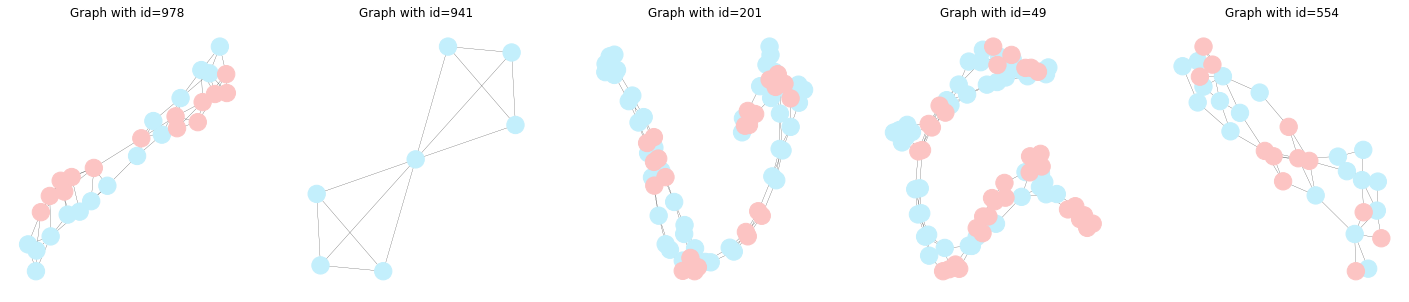

In [196]:
n_examples = 5

fix, ax = plt.subplots(nrows=1, ncols=n_examples, figsize=(5*n_examples, 5))

for i, rand_ix in enumerate(np.random.choice(dataset.indices(), 5)):
    curr_ax = ax[i]
    curr_ax.set_title(f'Graph with id={rand_ix}')
    
    pg_graph = dataset[rand_ix]
    nx_graph = to_networkx(pg_graph, to_undirected=True)
    colors = [COLORS[np.argmax(features)] for features in pg_graph.x]
    
    draw_colored_graph(nx_graph, colors, labels={}, ax=curr_ax)

## 1. Graph classification with GCN

At first, let's create data loaders for training, validation and testing. For that, we will use [PyG DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader) that combines input graphs into batches. One batch is represented as a single graph with multiple disconnected components.

In [197]:
from torch_geometric.loader import DataLoader

batch_size = 4
loader = DataLoader(dataset, batch_size=batch_size)

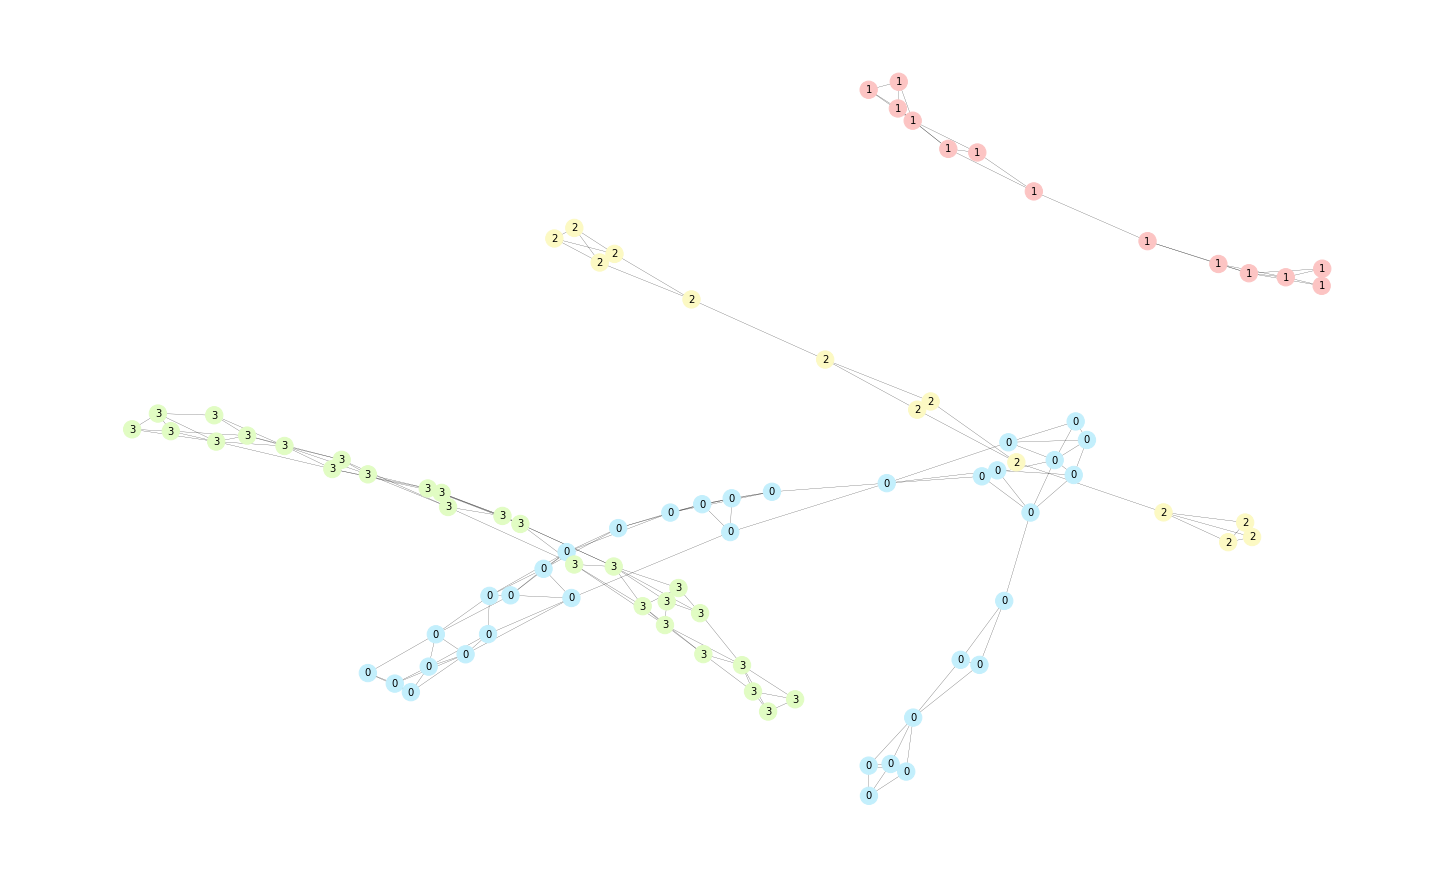

In [198]:
# Let's pick the first batch and visualize it.
# We will see that it is a simple graph with multiple disconnected components.
# Each component corresponds to a graph in the initial dataset.
# Here for illustration we label and color nodes according to these components

batch = loader.__iter__().next()
nx_graph = to_networkx(batch, to_undirected=True)

# mask = np.concatenate([
#     np.ones(batch.ptr[i+1] - batch.ptr[i], dtype=int) * i
#     for i in range(batch_size) 
# ])
mask = batch.batch.tolist()
colors = [COLORS[graph_idx] for graph_idx in mask]
labels = dict(zip(range(len(mask)), mask))


draw_colored_graph(nx_graph, colors=colors, labels=labels)

In [199]:
batch_size = 32
data_size = len(dataset)

all_indices_shuffled = np.arange(data_size)
np.random.shuffle(all_indices_shuffled)


train_loader = DataLoader(dataset[all_indices_shuffled[:int(data_size * 0.8)]], batch_size=batch_size)
val_loader = DataLoader(dataset[all_indices_shuffled[int(data_size * 0.8):int(data_size * 0.9)]], batch_size=batch_size)
test_loader = DataLoader(dataset[all_indices_shuffled[int(data_size * 0.9):]], batch_size=batch_size)

Since two classes are distributed not evenly in the dataset, a network always predicting the largest class can achive an accuracy $>0.5$. We consider the proportion of the largest class as the bottom accuracy that **should** be overperformed by the predictor.

In [200]:
def calculate_default_accuracy(loader):
    output = np.zeros(0,)
    for batch in loader:
        output = np.append(output,batch.y)
    return np.maximum(np.mean(output), 1 - np.mean(output))

In [201]:
train_default_accuracy = calculate_default_accuracy(train_loader)
val_default_accuracy = calculate_default_accuracy(val_loader)
test_default_accuracy = calculate_default_accuracy(test_loader)
print('Training set default accyracy: {:.4f}'.format(train_default_accuracy))
print('Validation set default accyracy: {:.4f}'.format(val_default_accuracy))
print('Test set default accyracy: {:.4f}'.format(test_default_accuracy))

Training set default accyracy: 0.5933
Validation set default accyracy: 0.6216
Test set default accyracy: 0.5893


In [202]:
epochs = 50 

### Task 1.1 – Implement GCN Layer

Pytorch Geometric provides the [Message Passing interface](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) that contains three main functions:
* `message()`, which defines how the message $\color{green}{\boldsymbol{m}_{ij}^{k}}$ is built,
* `aggregate()`, which defines how the messages are aggregated into $\color{red}{\boldsymbol{h}_{i}^{k}},$ 
* `propagate()`, which calls the `message()`, `aggregate()` functions.  

We will implement GCN layer according to the formula (4) on top this interface.

In [203]:
import torch
import torch.nn as nn

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

  A. Initialize a linear layer **nn.Linear** with arguments *in_features* and *out_features*. Passing through this layer corresponds to multiplication with a learnable matrix $\mathbf{\Theta}$ in formula (4)
  
  B. Apply the linear layer that you created in the *forward* function to  the node feature tensor 

  C. Create normalizing multipliers  **norm** using
    
  - function **degree** from torch_geometric.utils 
  - function **torch.sqrt** 
  
  
  D. Apply the *activation* function **self.activation** to the result of *self.propagate*

In [204]:
class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, activation=nn.functional.relu):
        super(GCN, self).__init__(aggr='add')
        self.activation = activation 
        # Task 1.1.A
        # YOUR CODE HERE
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        # Task 1.1.B
        # YOUR CODE HERE:
        x = self.lin(x)

        # Compute normalization.
        # Task 1.1.C
        # YOUR CODE HERE (~5 lines):

        source_idx = edge_index[0] 
        dest_idx = edge_index[1]

        source_degree = degree(source_idx)[source_idx]
        dest_degree = degree(dest_idx)[dest_idx]

        norm = 1/torch.sqrt(source_degree*dest_degree)
        
        # Start propagating messages.
        propagation  = self.propagate(edge_index, x=x, norm=norm)
        # Task 1.1.D
        # YOUR CODE HERE:
        output = self.activation(propagation)
        return output

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        # norm has shape [E, 1]

        # Normalize node features. This will make the highly connected modes more important if left oyut
        return norm.view(-1, 1) * x_j

In [205]:
# Check:
out_channels = 10
gcn_layer = GCN(in_channels=dataset.num_node_features, out_channels=out_channels)

rand_idx = np.random.randint(0, len(dataset))
graph = dataset[rand_idx]
output = gcn_layer(graph.x, graph.edge_index)

if output.shape == torch.Size([graph.num_nodes, out_channels]): 
    print('Good job!')
else:
    print('Error: layer should output a 2-dimensional tensor of shape (N, out_channels)')

Good job!


### Task 1.2 – Implement GNN with GCN

  A.  Set correct values for the **input_dim_layer** and **output_dim_layer** parameters
  
  B. Create a sequence of layers after message-passsing layers. Use the following functions:
  * **nn.Linear(in_dim, out_dim)**
  * **nn.Dropout(dropout)**
  * **nn.ReLU()**

  
  C. Apply **self.convs** in *forward*

  D. Apply a graph aggregation function. Choose from the functions:

  * **pyg_nn.global_add_pool**
  * **pyg_nn.global_mean_pool**
  * **pyg_nn.global_max_pool**

  They all have two arguments: node features tensor *x* and batch size *batch*


  E. Apply post-message-passing transformations *self.post_mp* 

In [206]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn


class GCN_GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0):
        super(GCN_GNN, self).__init__()
        
        self.dropout = dropout

        mp_layers = []
        mp_layers.append((GCN(input_dim, hidden_dim), 'x, edge_index -> x'))
        for i in range(3):
            # Task 1.2.A
            # YOUR CODE HERE:
            input_dim_layer = hidden_dim
            output_dim_layer = hidden_dim
            mp_layers.append((GCN(input_dim_layer, output_dim_layer), 'x, edge_index -> x'))

        
        self.convs = pyg_nn.Sequential('x, edge_index', mp_layers)

        # Task 1.2.B
        # YOUR CODE HERE:
        post_mp_layers = [
              nn.Linear(hidden_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout(dropout),
              nn.Linear(hidden_dim, output_dim),
              nn.Sigmoid()
        ]
        self.post_mp = nn.Sequential(*post_mp_layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Task 1.2.C
        # YOUR CODE HERE:
        x = self.convs(x, edge_index)
        
        # Task 1.2.D
        # YOUR CODE HERE:
        x = pyg_nn.global_add_pool(x, batch)
        
        # Task 1.2.E
        # YOUR CODE HERE:
        x = self.post_mp(x)

        return x

In [207]:
# Check:
hidden_dim = 10
gnn = GCN_GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=1, 
)

batch = loader.__iter__().next()
output = gnn(batch)

if output.shape == torch.Size([loader.batch_size, 1]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

Good job!


### Task 1.3 – Train GNN with GCN to predict classes of protein graphs

  A. Apply **model** to *batch* from *train_loader* and get predictions

  B. Extract labels from *batch*

  C. Apply the loss function

  D. Apply **model** to *batch* from *val_loader* and round the result to get predicted labels

  E. Get true label of *batch* from *val_loader*

  F. If the accuracy is better at this epoch, update *best_accuracy* and copy the current model to *best_model* using copy.deepcopy
  
  G. Create a GCN-GNN

In [211]:
from tqdm import tqdm
import copy

def cross_entropy_loss(x, labels):
    return F.binary_cross_entropy(x, labels)


def train(model, optimizer, train_loader, val_loader, epochs, loss_function = cross_entropy_loss):
    train_loss = []
    val_accuracy = []
    best_accuracy = 0.0
    for epoch in tqdm(range(epochs)):
        batch_train_loss = []
        batch_val_accuracy = []

        model.train()
        for batch in train_loader:
            # Task 1.3.A
            # YOUR CODE HERE:
            logits = model(batch)
            
            # Task 1.3.B
            # YOUR CODE HERE:
            labels = batch.y
            labels = labels.view(-1,1).float()

            # Task 1.3.C
            # YOUR CODE HERE:
            loss = loss_function(logits, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_train_loss.append(float(loss.data.numpy()))

        train_loss.append(np.mean(batch_train_loss))

        model.eval()
        for batch in val_loader:
            # Task 1.3.D
            # YOUR CODE HERE:
            pred = torch.round(model(batch))

            # Task 1.3.E
            # YOUR CODE HERE:
            labels = batch.y
            labels = labels.view(-1,1).float()
            
            batch_val_accuracy.append(np.mean((labels == pred).numpy()))

        val_accuracy.append(np.mean(batch_val_accuracy))
        # Task 1.3.F
        # YOUR CODE HERE:
        if val_accuracy[-1] > best_accuracy:
          print("I'm changing the model")
          best_accuracy = val_accuracy[-1]
          best_model = copy.deepcopy(model)
        
    return best_model, train_loss, val_accuracy


def plot_progress(train_loss, val_accuracy):
    fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    train_ax.plot(train_loss)
    train_ax.set_title('Train loss')
    train_ax.set_xlabel('Epoch')

    val_ax.plot(val_accuracy)
    val_ax.plot(val_default_accuracy*np.ones_like(val_accuracy), c='r', label = 'default_accuracy')
    val_ax.set_title('Val accuracy')
    val_ax.set_xlabel('Epoch')
    
    plt.legend()
    plt.show()
    
    
def evaluate(model, loader):
    model.eval()

    predictions = np.array([])
    labels = np.array([])

    for batch in loader:

        # Repeat what you have completed in 1.3.D
        # YOUR CODE HERE:
        pred = torch.round(model(batch))

        # Repeat what you have completed in 1.3.E
        # YOUR CODE HERE:
        true = batch.y
        true = true.view(-1,1).float()

        predictions = np.append(predictions, pred.detach())
        labels = np.append(labels, true)

    return np.mean(predictions == labels)

In [212]:
import torch.optim as optim

# Task 1.3.G
# YOUR CODE HERE:
hidden_dim = 10
model = GCN_GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=1)

optimizer = optim.Adam(model.parameters(), lr=.001)
epochs = 50

Training:

  2%|▏         | 1/50 [00:00<00:18,  2.59it/s]

I'm changing the model


 26%|██▌       | 13/50 [00:04<00:12,  2.86it/s]

I'm changing the model


 30%|███       | 15/50 [00:05<00:12,  2.77it/s]

I'm changing the model


 32%|███▏      | 16/50 [00:05<00:14,  2.39it/s]

I'm changing the model


 38%|███▊      | 19/50 [00:07<00:11,  2.60it/s]

I'm changing the model


 44%|████▍     | 22/50 [00:08<00:09,  2.81it/s]

I'm changing the model


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


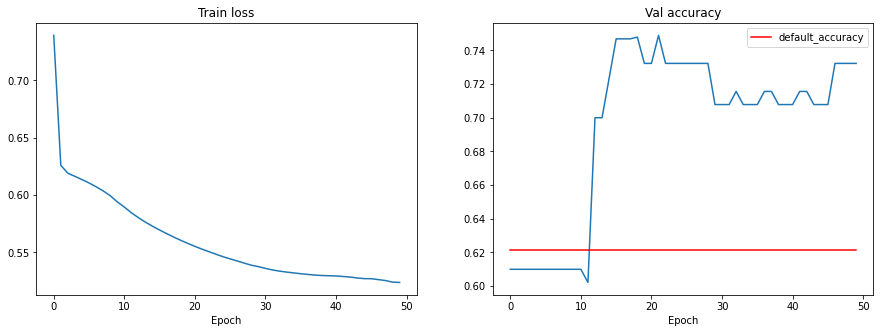

In [213]:
model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs)
plot_progress(train_loss, val_accuracy)

Evaluation:

In [ ]:
accuracy = evaluate(model, test_loader)
print('Accuracy:', accuracy)
if accuracy >= test_default_accuracy:
    print('Good job!')
else:
    print('Try better!')
baseline_accuracy = accuracy

### Task 1.4 – Train Graph Convolutional Network with modifications: different kernels, activations, loss functions and compare results  

  A. Initialize two instances **nn.Linear** for modifications according to formulas (6) and (7)
  
  B. Apply the instances you created to node features tensor **x** 

  C. Create normalizing multiplier for the normalization described in formula (8)

  D. Write to the  variable **norm** a unit tensor of size (1,1) using this function **torch.ones** in case we don't use normalization

  E. Complete the ouput of the GCN layer for modifications of the kernel

  F. Create a sequence of layers after message-passsing layers

  G. Select a graph pooling

  H. Suggest sets of hyperparameters for which we will train networks and choose the best one. During this process, we should find the best hyperparameters

In [172]:
class GCN(MessagePassing):
    def __init__( 
                  self, 
                  in_channels, 
                  out_channels, 
                  mode = 'basic', 
                  activation = nn.functional.relu, 
                  normalization_type = '1'):
        super(GCN, self).__init__(aggr='add')
        self.mode = mode
        self.activation = activation 
        self.normalization_type = normalization_type
        assert self.mode in ['basic', 'modification1', 'modification2'], "Wrong mode"
        assert self.normalization_type in ['None', '1', '2'], 'Wrong normalization type'

        
        if self.mode == 'basic':
          self.lin = nn.Linear(in_features=in_channels, out_features=out_channels) 
        elif self.mode in ['modification1', 'modification2']:
          # Task 1.4.A
          # YOUR CODE HERE
          self.lin1 = ...
          self.lin2 = ... 

    def forward(self, x, edge_index):
        if self.mode == 'basic':
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

            x = self.lin(x)
        elif self.mode in ['modification1', 'modification2']:
            # Task 1.4.B
            # YOUR CODE HERE
            x1 = ...
            x2 = ...

        source_idx = edge_index[0, :] # shape [E, out_dim]
        dest_idx = edge_index[1, :] # shape [E, out_dim]
        if self.normalization_type == '1':
            norm = 1 / torch.sqrt(
                degree(source_idx)[source_idx] * degree(source_idx)[dest_idx]
            ) # shape [E, out_dim]
        elif self.normalization_type == '2':
            # Task 1.4.C
            # YOUR CODE HERE
            norm = ...
        
        elif self.normalization_type == 'None':
            # Task 1.4.D
            # YOUR CODE HERE
            norm = ...
        

        if self.mode == 'basic':
            propagation = self.propagate(edge_index, x=x, norm=norm)
            output = self.activation(propagation) 
        elif self.mode == 'modification1':
            # Task 1.4.E
            # YOUR CODE HERE
            propagation = ...
            output = ...
        elif self.mode == 'modification2':
            # Task 1.4.E
            # YOUR CODE HERE
            propagation = ...
            output = ...
        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [173]:
class GCN_GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0, activation = nn.functional.relu, mode = 'basic', normalization_type = '1', num_layers = 3):
        super(GCN_GNN, self).__init__()
        
        self.dropout = dropout
        assert num_layers >=1, 'Wrong number of layers'
        layers = []
        layers.append(
            (GCN(input_dim, hidden_dim, mode = mode, activation = activation, normalization_type = normalization_type), 'x, edge_index -> x')
        )
        for i_l in range(num_layers - 1):
            layers.append(
                (GCN(hidden_dim, hidden_dim, mode = mode, activation = activation, normalization_type = normalization_type), 'x, edge_index -> x')
            )
        self.convs = pyg_nn.Sequential('x, edge_index', layers)

        # Task 1.4.F
        # YOUR CODE HERE
        post_mp_layers = [
                          ...
        ]
        self.post_mp = nn.Sequential(*post_mp_layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.convs(x, edge_index) # shape [N, hidden_dim]
        # Task 1.4.G
        # YOUR CODE HERE
        x = ... # shape [B, hidden_dim], B is batch size
        
        x = self.post_mp(x) # shape [B, out_dim]

        return x

In [ ]:
from tabulate import tabulate

In [ ]:
def sigmoid(x):
    return 2*torch.sigmoid(x) - 1


activation_functions_dict = {
    'tanh': torch.tanh,
    'sigmoid': sigmoid,
    'relu': F.relu
}
def cross_entropy_loss(x, labels):
    return F.binary_cross_entropy(x, labels)

def hinge_loss(x, labels):
    return torch.mean(torch.maximum(torch.zeros_like(labels), 1 - (2*(x - 1/2))*(2*(labels - 1/2))))
def squared_hinge_loss(x, labels):
    return torch.mean(torch.maximum(torch.zeros_like(labels), 1 - (2*(x - 1/2))*(2*(labels - 1/2)))**2)

loss_functions_dict = {
    'cross_entropy': cross_entropy_loss,
    'hinge': hinge_loss,
    'squared_hinge': squared_hinge_loss
}
# Task 1.4.H
# YOUR CODE HERE
# [num_layers, convolution_type, normalization_type, dropout, activation_function, loss_function]
hyperparameters_sets = [
                        [4, ..., ..., 0.0, 'tanh', ...],
                        [4, 'basic', '1', ..., ..., 'cross_entropy'],
]




In [ ]:
table = [['# model', 'Number of layers', 'Convolution type', 'Normalization type', 'Dropout', 'Activation function', 'Loss function', 'Test set accuracy']]
table.append(['0/ Baseline', 3, 'basic', '1', 0.0, 'relu', 'cross_entropy', baseline_accuracy])
best_model = model 
best_accuracy = baseline_accuracy
for i_hs, hyperparameters_set in enumerate(hyperparameters_sets):
    num_layers, convolution_type, normalization_type, dropout, activation_function_name, loss_function_name = hyperparameters_set
    model = GCN_GNN(
                input_dim=dataset.num_node_features,
                hidden_dim=16,
                output_dim=1,
                dropout=dropout,
                mode = convolution_type,
                normalization_type = normalization_type,
                activation = activation_functions_dict[activation_function_name],
                num_layers = num_layers
            )
    optimizer = optim.Adam(model.parameters(), lr=.001)
    model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs, loss_function = loss_functions_dict[loss_function_name])
    plot_progress(train_loss, val_accuracy)
    accuracy = evaluate(model, test_loader)
    print('Test set accuracy: {:.5f}'.format(accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = copy.deepcopy(model)
    table.append([str(i_hs+1)] + hyperparameters_set + [accuracy])




In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
print('Accuracy on the test set of the best model:', best_accuracy)
if best_accuracy > baseline_accuracy:
    print('Good job!')
else:
    print('Try better!')
best_gcn_accuracy = best_accuracy

## 2. Graph Isomorphic Network


### Task 2.1 Implement GIN Layer



A.  Set correct values for the **layer_in_features** and **layer_out_features** parameters

B. Implement passing through mlp. Don't forget to activate output of each layer

C. Implement *forward* function 

In [ ]:
from torch.autograd import Variable

dtype = torch.FloatTensor

class GIN(MessagePassing):
    def __init__(self, in_channels, out_channels, activation=nn.functional.relu, mlp_num_layers = 3, mlp_hidden_channels = 10, aggr = 'sum'):
        super(GIN, self).__init__(aggr=aggr)
        self.activation = activation 
        self.mlp_num_layers = mlp_num_layers
        self.mlp_layers = []
        for i_l in range(mlp_num_layers):
            # Task 2.1.A
            # YOUR CODE HERE
            layer_in_features = ...
          
            if i_l == mlp_num_layers -1:
                layer_out_features = out_channels
            else:
                layer_out_features = mlp_hidden_channels

            self.mlp_layers.append(nn.Linear(in_features=layer_in_features, out_features=layer_out_features))
        self.eps = nn.Parameter(torch.Tensor(1,))
        # Initialization of epsilon
        nn.init.trunc_normal_(self.eps)

    def mlp(self, x):
        # Task 2.1.B
        # YOUR CODE HERE
        for mlp_layer in self.mlp_layers:
            ...
        return x


    def forward(self, x, edge_index):
        # Task 2.1.C
        # YOUR CODE HERE
        propagation = ...
        output = ...
        
        return output

    def message(self, x_j, norm):
        
        return x_j

In [ ]:
# Check:
out_channels = 10
gcn_layer = GIN(in_channels=dataset.num_node_features, out_channels=out_channels)

rand_idx = np.random.randint(0, len(dataset))
graph = dataset[rand_idx]
output = gcn_layer(graph.x, graph.edge_index)

if output.shape == torch.Size([graph.num_nodes, out_channels]): 
    print('Good job!')
else:
    print('Error: layer should output a 2-dimensional tensor of shape (N, out_channels)')

### Task 2.2 – Implement GNN with GIN


A. Create a sequence of layers after message-passsing layers

B. Select a graph pooling

In [ ]:
class GIN_GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0, aggr = 'sum', mlp_num_layers = 2, mlp_hidden_channels = None, num_layers = 3, activation = nn.functional.relu):
        super(GIN_GNN, self).__init__()
        
        self.dropout = dropout
        self.activation = activation
        if mlp_hidden_channels is None:
            self.mlp_hidden_channels = hidden_dim
        else:
            self.mlp_hidden_channels = mlp_hidden_channels

        self.layers = []
        for i_l in range(num_layers):
            if i_l == 0:
                input_dim_layer = input_dim
            else:
                input_dim_layer = hidden_dim
            self.layers.append(
                                  (GIN(input_dim_layer, hidden_dim, mlp_hidden_channels = self.mlp_hidden_channels, mlp_num_layers = mlp_num_layers, aggr = aggr, activation = self.activation), 'x, edge_index -> x')
                              )
        self.convs = pyg_nn.Sequential('x, edge_index', self.layers)

        # Task 2.2.A 
        # YOUR CODE HERE:
        post_mp_layers = [
                          ...
        ]
        self.post_mp = nn.Sequential(*post_mp_layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.convs(x, edge_index) # shape [N, hidden_dim]
        
        # Task 2.2.B
        # YOUR CODE HERE:
        x = ... # shape [B, hidden_dim], B is batch size
        
        x = self.post_mp(x) # shape [B, out_dim]

        return x

In [ ]:
hidden_dim = 10
gnn = GIN_GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=dataset.num_classes, 
)

batch = loader.__iter__().next()
output = gnn(batch)

if output.shape == torch.Size([loader.batch_size, dataset.num_classes]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

### Task 2.3 – Train GNN with GCN to predict classes of protein graphs

A. Create a GIN-GNN

In [ ]:
# Task 2.3.A
# YOUR CODE HERE:
model = GIN_GNN(
    ...
)
optimizer = optim.Adam(model.parameters(), lr=.001)

Train:

In [ ]:
model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs)
plot_progress(train_loss, val_accuracy)

Evaluation:

In [ ]:
accuracy = evaluate(model, test_loader)

print('Accuracy:', accuracy)
if accuracy >= test_default_accuracy:
    print('Good job!')
else:
    print('Try better!')
baseline_accuracy = accuracy

### Task 2.4 - Select hyperparameters of GIN-GNN

A. Suggest sets of hyperparameters 

In [ ]:
activation_functions_dict = {
    'tanh': torch.tanh,
    'sigmoid': sigmoid,
    'relu': F.relu
}

loss_functions_dict = {
    'cross_entropy': cross_entropy_loss,
    'hinge': hinge_loss,
    'squared_hinge': squared_hinge_loss
}
# Task 2.4.A
# YOUR CODE HERE:
# [num_layers, mlp_num_layers, aggr, dropout, activation_function, loss_function]
hyperparameters_sets = [
                        [..., 2, ..., 0.0, ..., 'cross_entropy'],
                        [2, ..., 'max', ..., 'relu', ...],
]

In [ ]:
table = [['# model', 'Number of layers', 'Number of layers in the MLP', 'Aggregation type', 'Dropout', 'Activation function', 'Loss function', 'Test set accuracy']]
table.append(['0/ Baseline', 3, 2, 'sum', 0.0, 'relu', 'cross_entropy', baseline_accuracy])
best_model = model 
best_accuracy = baseline_accuracy
for i_hs, hyperparameters_set in enumerate(hyperparameters_sets):
    num_layers, mlp_num_layers, aggr, dropout, activation_function_name, loss_function_name = hyperparameters_set
    model = GIN_GNN(
                input_dim=dataset.num_node_features,
                hidden_dim=16,
                output_dim=1,
                dropout=dropout,
                mlp_num_layers = mlp_num_layers,
                aggr = aggr,
                activation = activation_functions_dict[activation_function_name],
                num_layers = num_layers
            )
    optimizer = optim.Adam(model.parameters(), lr=.001)
    model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs, loss_function = loss_functions_dict[loss_function_name])
    plot_progress(train_loss, val_accuracy)
    accuracy = evaluate(model, test_loader)
    print('Test set accuracy: {:.5f}'.format(accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = copy.deepcopy(model)
    table.append([str(i_hs+1)] + hyperparameters_set + [accuracy])

In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
print('Accuracy on the test set of the best model:', best_accuracy)
if best_accuracy > baseline_accuracy:
    print('Good job!')
else:
    print('Try better!')
best_gin_accuracy = best_accuracy

## 3. Graph classification with GAT

Let's now implement Graph Attention Layer and perform the same graph classification procedure on PROTEINS dataset with a new GNN that contains GAT layers.

### Task 3.1 – Implement GAT Layer

We will implement multi-head GAT layer according to the formula (11) on top PyG Message-Passing interface.

  A. Initialize a linear layer **nn.Linear** with arguments *in_features* and *out_features*. Passing through this layer corresponds to multiplication with a learnable matrix $\mathbf{\Theta}$ in formula (11)
  
  B. Create a learnable attention tensor of shape $\left(\textbf{ 1, num\_heads,2*out\_channels  }\right)$ that is used in formula (12). Have a look at *self.eps* initialization in section 2.1. Use **nn.init.xavier_uniform_** for initialization

  C. Implement *message* function for *GAT-layer* using the following functions:
  
  * **.view** to reshape a tensor
  * **torch.cat([tensor1, tensor2, ...], dim = ...)**  to concatenate tensors
  * **.sum(axis)** for summing a tensor along some axis
  * **.unsqueeze(axis)** to add an axis to shape of a tensor
  * **F.leaky_relu()** as activation
  * **pyg_utils.softmax(input, index)**


In [ ]:
import torch_geometric.utils as pyg_utils

class GAT(MessagePassing):
    def __init__(self, in_channels, out_channels, num_heads, activation = F.relu):
        super(GAT, self).__init__(aggr='add')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.activation = activation
        
        # Task 3.1.A
        # YOUR CODE HERE:
        self.lin = ...
        
        # Task 3.1.B
        # YOUR CODE HERE:
        self.att = ...

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # Apply linear transformation to the node feature matrix.
        x = self.lin(x)

        # Start propagating messages.
        return self.activation(self.propagate(edge_index=edge_index, x=x))

    def message(self, x_i, x_j, index):
        # Constructs messages to node i for each edge (j, i).
        # x_i – feature vectors of target nodes corresponding to i-th index, i.e. x[edge_index[1]]
        # x_j – feature vectors of source nodes corresponding to j-th index, i.e. x[edge_index[0]]
        # index – target (i-th) nodes indices, i.e. edge_index[1]

        # Task 3.1.C
        # YOUR CODE HERE (~6 lines):
        ...
        
        return (alpha * x_j).mean(dim=1)

In [ ]:
# Check:
out_channels = 10
num_heads = 3
gat_layer = GAT(in_channels=dataset.num_node_features, out_channels=out_channels, num_heads=num_heads)

rand_idx = np.random.randint(0, len(dataset))
graph = dataset[rand_idx]
output = gat_layer(graph.x, graph.edge_index)

if output.shape == torch.Size([graph.num_nodes, out_channels]): 
    print('Good job!')
else:
    print('Error: layer should output a 2-dimensional tensor of shape (N, out_channels)')

### Task 3.2 – Implement GNN with GAT

A. Create a sequence of layers after message-passsing layers

B. Select a graph pooling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn


class GAT_GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, dropout=0.0, activation = F.relu, num_layers = 3):
        super(GAT_GNN, self).__init__()
        
        self.dropout = dropout
        layers = []
        layers.append(
            (GAT(input_dim, hidden_dim, num_heads, activation = activation), 'x, edge_index -> x')
        )
        for i_l in range(num_layers - 1):
            layers.append(
                (GAT(hidden_dim, hidden_dim, num_heads, activation = activation), 'x, edge_index -> x')
            )
        self.convs = pyg_nn.Sequential('x, edge_index', layers)

        # Task 3.2.A
        # YOUR CODE HERE:
        post_mp_layers = [
                          ...
        ]
        self.post_mp = nn.Sequential(*post_mp_layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.convs(x, edge_index)
        
        # Task 3.2.B
        # YOUR CODE HERE:
        x = ...
        
        x = self.post_mp(x)

        return x

In [ ]:
# Check:
hidden_dim = 10
num_layers = 3
num_heads = 8
dropout = 0.0

gnn = GAT_GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=1, 
    num_heads=num_heads,
    num_layers = num_layers,
    dropout = dropout
)

batch = loader.__iter__().next()
output = gnn(batch)

if output.shape == torch.Size([loader.batch_size, 1]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

### Task 3.3 – Train GNN with GAT to predict classes of protein graphs

A. Create a GIN-GNN

In [ ]:
# Task 3.3.A
# YOUR CODE HERE:
model = GAT_GNN(
    ...
)
optimizer = optim.Adam(model.parameters(), lr=.001)

Training:

In [ ]:
model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs)
plot_progress(train_loss, val_accuracy)

Evaluation:

In [ ]:
accuracy = evaluate(model, test_loader)

print('Accuracy:', accuracy)
if accuracy >= test_default_accuracy:
    print('Good job!')
else:
    print('Try better!')
baseline_accuracy = accuracy

### Task 3.4 - Select hyperparameters of GAT-GNN

A. Suggest sets of hyperparameters 

In [ ]:
activation_functions_dict = {
    'tanh': torch.tanh,
    'sigmoid': sigmoid,
    'relu': F.relu
}

loss_functions_dict = {
    'cross_entropy': cross_entropy_loss,
    'hinge': hinge_loss,
    'squared_hinge': squared_hinge_loss
}
# Task 3.4.A
# YOUR CODE HERE:
# [num_layers, num_heads, dropout, activation_function, loss_function]
hyperparameters_sets = [
                        [..., 8, ..., 'tanh', ...],
                        [2, ..., 0.4, ..., 'cross_entropy'],
]



In [ ]:
table = [['# model', 'Number of layers', 'Number of heads' 'Dropout', 'Activation function', 'Loss function', 'Test set accuracy']]
table.append(['0/ Baseline', num_layers, num_heads, dropout, 'relu', 'cross_entropy', baseline_accuracy])
best_model = model 
best_accuracy = baseline_accuracy
for i_hs, hyperparameters_set in enumerate(hyperparameters_sets):
    num_layers, num_heads, dropout, activation_function_name, loss_function_name = hyperparameters_set
    model = GAT_GNN(
        input_dim=dataset.num_node_features, 
        hidden_dim=16, 
        output_dim=1, 
        num_heads=num_heads,
        num_layers = num_layers 
    )
    optimizer = optim.Adam(model.parameters(), lr=.001)
    model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs, loss_function = loss_functions_dict[loss_function_name])
    plot_progress(train_loss, val_accuracy)
    accuracy = evaluate(model, test_loader)
    print('Test set accuracy: {:.5f}'.format(accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = copy.deepcopy(model)
    table.append([str(i_hs+1)] + hyperparameters_set + [accuracy])

In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
print('Accuracy on the test set of the best model:', best_accuracy)
if best_accuracy > baseline_accuracy:
    print('Good job!')
else:
    print('Try better!')
best_gat_accuracy = best_accuracy

In [ ]:
table = [['GNN type', 'Best model accuracy'], ['GCN', '{:.5f}'.format(best_gcn_accuracy)], ['GIN', '{:.5f}'.format(best_gin_accuracy)], ['GAT', '{:.5f}'.format(best_gat_accuracy)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

# Graph regression: QM9 dataset

QM9 is a [molecular dataset](https://www.nature.com/articles/sdata201422) standardized in machine learning as a chemical property prediction benchmark. It consists of small molecules (up to 29 atoms per molecule). Atoms contain positional coordinates embedded in a 3D space, a one-hot encoding vector that defines the type of molecule (H, C, N, O, F) and an integer value with the atom charge. For each molecule, authors of the dataset provide computed geometries minimal in energy, corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization. Any of these values can be considered as targets in the graph regression problem. In this seminar, we will predict one of them, the energy of the highest occupied molecular orbital $\epsilon_{\text{HOMO}}$.

There are examples of some molecules from QM9 constructed using [PyMOL](https://pymol.org/2/):

<img src="https://i.ibb.co/qDv7Xy0/qm9-examples-v2.jpg" alt="qm9-examples-v2" border="0">

In [ ]:
from torch_geometric.datasets import QM9

In [ ]:
# In this seminar we will consider only a small part of this dataset
# (in total it contains ~134k molecules)
N = 10000
dataset = QM9(root='data/QM9')[:N]

In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_features}')

In [ ]:
n_examples = 5
atom_types = ['H', 'C', 'N', 'O', 'F']

fix, ax = plt.subplots(nrows=1, ncols=n_examples, figsize=(5*n_examples, 5))

for i, rand_ix in enumerate(np.random.choice(dataset.indices(), 5)):
    curr_ax = ax[i]
    curr_ax.set_title(f'Graph with id={rand_ix}')
    
    pg_graph = dataset[rand_ix]
    nx_graph = to_networkx(pg_graph, to_undirected=True)
    colors = [COLORS[np.argmax(features[:4])] for features in pg_graph.x]
    labels = {
        i: atom_types[np.argmax(features[:4])]
        for i, features in enumerate(pg_graph.x)
    }
    
    draw_colored_graph(nx_graph, colors, labels=labels, ax=curr_ax)

In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 32
data_size = len(dataset)

all_indices_shuffled = np.arange(N)
np.random.shuffle(all_indices_shuffled)

train_loader = DataLoader(dataset[all_indices_shuffled[:int(data_size * 0.8)]], batch_size=batch_size)
val_loader = DataLoader(dataset[all_indices_shuffled[int(data_size * 0.8):int(data_size * 0.9)]], batch_size=batch_size)
test_loader = DataLoader(dataset[all_indices_shuffled[int(data_size * 0.9):]], batch_size=batch_size)

Since the signle value is to be predicted, a network that always outputs the mean of this value in the dataset,  the MSE of such prediction equals to variance. We consider the variance of the predicted value as the base MSE that should be overperformed by the predictor.

In [ ]:
def calculate_default_mse(loader, target_ix):
    output = np.zeros(0,)
    for batch in loader:
        output = np.append(output,batch.y[:, target_ix])
    return np.var(output)

In [ ]:
# In this seminar we will predict the HOMO energy.
# This value goes the 3rd in the list of all targets in the PyG QM9 dataset
# For details, see https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9
target_homo_ix = 2


train_default_mse = calculate_default_mse(train_loader, target_homo_ix)
val_default_mse = calculate_default_mse(val_loader, target_homo_ix)
test_default_mse = calculate_default_mse(test_loader, target_homo_ix)
print('Training set default MSE: {:.4f}'.format(train_default_mse))
print('Validation set default MSE: {:.4f}'.format(val_default_mse))
print('Test set default MSE: {:.4f}'.format(test_default_mse))

### Task 4.1 – Implement GNN for graph regresion

Architecture is up to you. Feel free to use GCN, GIN or GAT as well as [any other](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) layers.

**It's time to create a mutant!**

<div>
<img src="https://naked-science.ru/wp-content/uploads/2016/04/article_14231592739196-1200x720.jpg" width="500"/>
</div>

A. Create a sequence of layers after message-passsing layers

B. Select a graph pooling

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0, layers_types = ['GCN', 'GCN', 'GCN'], activation = nn.functional.relu, gcn_mode = 'basic', gcn_normalization_type = '1', gat_num_heads = 16, gin_mlp_num_layers = 3, gin_aggr = 'sum'):
        super(GNN, self).__init__()
        
        self.dropout = dropout

        

        layers = []
        for i_l, lt in enumerate(layers_types):
            assert lt in ['GCN', 'GIN', 'GAT'], 'Wrong layer type'
            if i_l == 0:
                input_dim_layer = input_dim
            else:
                input_dim_layer = hidden_dim
            if lt is 'GCN':
              layers.append(
                  (GCN(input_dim_layer, hidden_dim, mode = gcn_mode, activation = activation, normalization_type = gcn_normalization_type), 'x, edge_index -> x')
                  )
            elif lt is 'GIN':
              layers.append(
                  (GIN(input_dim_layer, hidden_dim, activation = activation, aggr = gin_aggr, mlp_num_layers = gin_mlp_num_layers), 'x, edge_index -> x')
                  )
            elif lt in 'GAT':
              layers.append(
                  (GAT(input_dim_layer, hidden_dim, gat_num_heads, activation = activation), 'x, edge_index -> x')
                  )
        self.convs = pyg_nn.Sequential('x, edge_index', layers)

        # Task 4.1.A
        # YOUR CODE HERE:
        post_mp_layers = [
                          ...
        ]
        self.post_mp = nn.Sequential(*post_mp_layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GCN layers with non-linearities (ReLU)
        x = self.convs(x, edge_index) # shape [N, hidden_dim]
        
        # Task 4.1.B
        # YOUR CODE HERE:
        x = ...# shape [B, hidden_dim], B is batch size
        
        # Apply post-message-passing transformations
        x = self.post_mp(x) # shape [B, out_dim]

        return x

In [ ]:
# Check:
hidden_dim = 10

gnn = GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=dataset.num_classes, # 19 
)

rand_idx = np.random.randint(0, len(train_loader))
graph = train_loader.__iter__().next()

output = gnn(graph)

if output.shape == torch.Size([train_loader.batch_size, dataset.num_classes]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

### Task 4.2 – Train GNN

Keep in mind that now we'are going to predict a real value instead of class so we need to change loss function and the way we evaluate the model.

A. Suggest sets of hyperparameters 

In [ ]:
import torch.nn.functional as F

from tqdm import tqdm

def mse_loss(predictions, targets):
    return F.mse_loss(predictions, targets)


# Wrapper for different architectures
def model_forward(model, batch):
    if model.__class__.__name__ == 'GNN':
        return model(batch)
    if model.__class__.__name__ == 'SchNet':
        return model(batch.z, batch.pos, batch.batch)
    raise Exception('Unknown model')


def train_graph_regression(model, optimizer, train_loader, val_loader, target_ix, epochs):
    train_mse = []
    val_mse = []

    # for epoch in range(epochs):
    for epoch in tqdm(range(epochs)):
        batch_train_mse = []
        batch_val_mse = []

        model.train()
        for batch in train_loader:
        # for batch in tqdm(train_loader, desc=f'Epoch {epoch} train'):
            # Get model predictions
            predictions = model_forward(model, batch).squeeze()
            
            # Get ground-truth values
            targets = batch.y[:, target_ix].squeeze() # [B, 1] -> [B]
            
            # Calculate loss
            loss = mse_loss(predictions, targets)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_train_mse.append(float(loss.data.numpy()))

        train_mse.append(np.mean(batch_train_mse))

        model.eval()
        # for batch in tqdm(val_loader, desc=f'Epoch {epoch} valid'):
        for batch in val_loader:
            predictions = model_forward(model, batch).squeeze()
            targets = batch.y[:, target_ix].squeeze()
            batch_val_mse.append(mse_loss(predictions, targets).detach().numpy())

        val_mse.append(np.mean(batch_val_mse))
        
    return model, train_mse, val_mse


def plot_progress(train_mse, val_mse):
    fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    train_ax.plot(train_mse)
    train_ax.set_title('Train MSE')
    train_ax.set_xlabel('Epoch')
    train_ax.set_xlim(left = 1)
    train_ax.set_ylim(top = np.max(train_mse[1:]), bottom = np.min(train_mse[1:]))

    val_ax.plot(val_mse)
    val_ax.plot(val_default_mse *np.ones_like(val_mse), c='r', label = 'default_mse')
    val_ax.set_title('Val MSE')
    val_ax.set_xlabel('Epoch')

    plt.legend()
    plt.show()
    
def evaluate_graph_regression(model, loader, target_ix):
    loss = []
    model.eval()
    # for batch in tqdm(loader):
    for batch in loader:

        # Get predicted values
        pred = model_forward(model, batch).squeeze()

        # Get ground-truth values
        true = batch.y[:, target_ix].squeeze()

        loss.append(mse_loss(pred, true).detach().numpy())

    return np.mean(loss)

In [ ]:
import torch.optim as optim


activation_functions_dict = {
    'tanh': torch.tanh,
    'sigmoid': sigmoid,
    'relu': F.relu
}

# Task 4.2.A
# YOUR CODE HERE:
# [layes_types, gcn_mode, gcn_normalization, gin_mlp_num_layers, gin_aggr, gat_num_heads, dropout, activation_function]
hyperparameters_sets = [
                        [['GCN', 'GIN', 'GAT'], ..., ..., ..., ..., ..., ..., ...],
]



In [ ]:
table = [['# model', 'Layers types', 'GCN mode' 'GCN noramlization type', 'GIN MLP number of layers', 'GIN aggregation', 'GAT number of heads', 'Dropout', 'Activation function', 'Test set MSE']]
best_model = None
best_loss = np.inf
target_homo_ix = 2
epochs = 100
for i_hs, hyperparameters_set in enumerate(hyperparameters_sets):
    layers_types, gcn_mode, gcn_normalization_type, gin_mlp_num_layers, gin_aggr, gat_num_heads, dropout, activation_function_name  = hyperparameters_set
    model = GNN(
        input_dim=dataset.num_node_features, 
        hidden_dim=16, 
        output_dim=1, 
        dropout=0.0, 
        layers_types = layers_types, 
        activation = nn.functional.relu, 
        gcn_mode = 'basic', 
        gcn_normalization_type = '1', 
        gin_mlp_num_layers = gin_mlp_num_layers,
        gin_aggr = gin_aggr,
        gat_num_heads = gat_num_heads
    )
    optimizer = optim.Adam(model.parameters(), lr=.001)
    model, train_loss, val_loss = train_graph_regression(model, optimizer, train_loader, val_loader, target_homo_ix, epochs)
    plot_progress(train_loss, val_loss)
    loss = evaluate_graph_regression(model, test_loader, target_homo_ix)
    print('Test set MSE: {:.5f}'.format(loss))
    if loss < best_loss:
        best_loss = loss
        best_model = copy.deepcopy(model)
    table.append([str(i_hs+1)] + hyperparameters_set + [loss])







In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
print('MSE on the test set of the best model:', best_loss)
if best_loss < test_default_mse:
    print('Good job!')
else:
    print('Try better!')

# SchNet and Equivariance

* [original paper](https://arxiv.org/abs/1706.08566)
* [original code](https://github.com/atomistic-machine-learning/SchNet)

SchNet is one of the first GCN models where authors attempted to take into accout geometry of the underlying data. 

In case of molecular graphs, each node $v_i$ of graph $G$ is an atom that is characterized by its vector of features $\boldsymbol{z}_i\in\mathbb{R}^d$ and by its position $\boldsymbol{r}_i\in\mathbb{R}^3$. In general, the graph itself may not include the information about spatial relations between atoms. To take it into account, rotation-invariant _continuous-filter convolutions_ were proposed:

$$
z'_i=\sum_{j=1}^Nz_j\circ\boldsymbol{W}(\boldsymbol{r_i}-\boldsymbol{r}_j),\tag{9}
$$

where $\boldsymbol{W}(\boldsymbol{r_i}-\boldsymbol{r}_j)$ is a trainable and relative-distance-dependent filter, and $\circ$ denotes element-wise multiplication.

One of the most important aspects of learning on 3D objects is the fact that in most cases we do not have the fixed and preferred global orientation. When constructing geometric-learning models, one should take it into account and impose additional symmetry-related constraints on the model. This constraint is called $equivariance$ can be required with respect to rotations and translations in case of 3D space. More formally, having some group $G$ (e.g. group of rotations in 3D) and a function $f:X\to Y$, this function is called $G$-$equivariant$ if for any $x\in{X}$ and for any $g\in{G}$

$$
f(\rho_X(g)(x))=\rho_Y(g)(f(x)),\tag{10}
$$

where $\rho_X:G\to{GL}(X)$ and $\rho_Y:G\to{GL}(Y)$ are representations of group $G$ on spaces $X$ and $Y$ respectively. In case if $\rho_Y=1$, function $f$ is called $G$-$invariant$.

In case of (9), filters $\boldsymbol{W}(\boldsymbol{r_i}-\boldsymbol{r}_j)$ are constructed to be rotation- and translation-invariant. To do it, we will make them depend only on distances between molecules:

$$
\boldsymbol{W}(\boldsymbol{r_i}-\boldsymbol{r}_j)=\boldsymbol{W}(\|\boldsymbol{r_i}-\boldsymbol{r}_j\|).\tag{11}
$$

In SchNet, these filters are constructed as MLPs that operate on $K$-dimensional radial basis finctions $\{\boldsymbol{e}_{ij}\}$:

$$
\boldsymbol{W}(\boldsymbol{r_i}-\boldsymbol{r}_j)=
\sigma(\boldsymbol{W}_2\sigma(\boldsymbol{W}_1\boldsymbol{e}_{ij})),\tag{12}
$$

where 

$$
\boldsymbol{e}_{ij}=\big(e_{ij}^{(1)},\dots,e_{ij}^{(K)}\big)^{\text{T}}, \tag{13}
$$

and

$$
e_{ij}^{(k)}=exp\big(-\gamma\big[\|\boldsymbol{r}_i-\boldsymbol{r}_j\|-\mu_k\big]^2\big).\tag{14}
$$

Here, $\sigma$ is non-linearity, $K$, $\gamma$ and $\{\mu_k\}$ are adjustable hyperparameters and $\boldsymbol{W}_1$ and $\boldsymbol{W}_2$ are trainable matrices.

In the original paper, $\sigma(x)=\ln(0.5e^x+0.5)$, $K=300$, $0Å\leq\mu_k\leq30Å$ every $0.1$Å, and $\gamma=10$Å.

<div>
<img src="https://user-images.githubusercontent.com/7134790/65094886-d8dda800-d9f9-11e9-92e8-2737c4913ab7.png" width="800"/>
</div>

Here we will not implement SchNet by ourselves, but we can [import it from PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.SchNet) and train on QM9.

In [ ]:
from torch_geometric.nn import SchNet

# YOUR CODE HERE
model = SchNet()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [ ]:
epochs = 5
target_homo_ix = 2
model, train_mse, val_mse = train_graph_regression(
    model, 
    optimizer, 
    train_loader, 
    val_loader, 
    target_homo_ix, 
    epochs
)
plot_progress(train_mse, val_mse)

In [ ]:
loss = evaluate_graph_regression(model, test_loader, target_homo_ix)

print('MSE:', loss)
if loss <= 0.2:
    print('Good job!')
else:
    print('Try better!')

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [ ]:
pytorch_total_params

# Further reading

In order to read more about geometric learning, message passing and equivariance, we refer to the following sources:
* [Geometric Learning](https://arxiv.org/abs/2104.13478)
* [Directional Message Passing](https://arxiv.org/abs/2003.03123)
* [E(n)-equivariant graph neural networks](https://arxiv.org/abs/2102.09844)
* [SE(3)-Transformers](https://arxiv.org/abs/2006.10503)